In [1]:
from lad_utils import *
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.style.use('seaborn-colorblind')

In [2]:
chipseq_data = 'lb1_processed_chipseq_data/' # location of bedgraph and bigwig files for all cell types used in final analyses

# HMM predictions

In [7]:
lad_hmm_out = 'LB1_HMM_predictions' # where to save predictions

for n_states in range(2,6,1):
    dfs = []
    for ct in all_cts:
        df = hmm_predict(ct, 
                         f'LB1_trained_HMMs/{n_states}_state_LAD_HMM.json', 
                         chipseq_data,
                        print_status_updates=False)
        df['cell_type'] = ct
        dfs.append(df)


    alldfs = pd.concat(dfs, sort=False)

    alldfs.to_csv(f'{lad_hmm_out}/LB1_dat_{n_states}state.tsv',
                 sep='\t', index=False)

# save to BED files

In [2]:
n_states = 2

lb1_dat = pd.read_table(f'LB1_HMM_predictions/LB1_dat_{n_states}state.tsv')

save_dat_to_bed(lb1_dat, ['nonLAD','LAD'],
               f'LADs_{n_states}state', encode_blacklist)

In [3]:
n_states = 3

lb1_dat = pd.read_table(f'LB1_HMM_predictions/LB1_dat_{n_states}state.tsv')

save_dat_to_bed(lb1_dat, ['nonLAD','T2LAD','T1LAD'],
               f'LADs_{n_states}state', encode_blacklist)

In [4]:
n_states = 4

lb1_dat = pd.read_table(f'LB1_HMM_predictions/LB1_dat_{n_states}state.tsv')

save_dat_to_bed(lb1_dat, ['nonLAD','T3LAD','T2LAD','T1LAD'],
               f'LADs_{n_states}state', encode_blacklist)

In [5]:
n_states = 5

lb1_dat = pd.read_table(f'LB1_HMM_predictions/LB1_dat_{n_states}state.tsv')

save_dat_to_bed(lb1_dat, ['nonLAD','T4LAD','T3LAD','T2LAD','T1LAD'],
               f'LADs_{n_states}state', encode_blacklist)

# calculate statistics to compare different state number models

## AIC and BIC

As described [here](https://rdrr.io/cran/HMMpa/man/AIC_HMM.html)

**size (T)**: length of the time-series of observations x (also T).

**m**: number of states in the Markov chain of the model.

**k**: single numeric value representing the number of parameters of the underlying distribution of the observation process (e.g. k=2 for the normal distribution (mean and standard deviation)).

**logL**: logarithmized likelihood of the model.

**AIC** = -2 logL + 2p

**BIC** = -2 logL + p log(T),

**p**: denotes the number of independent parameters of the model

In case of a HMM as provided by this package, where k and m are defined as in the arguments above, p can be calculated as follows:

p = m^2 + km - 1.

In [3]:
tier_one_cts = []

tier_two_cts = []

with open('tier_one_cts.txt','r') as f:
    for val in f.readlines():
        tier_one_cts.append(val.strip())
        
with open('tier_two_cts.txt','r') as f:
    for val in f.readlines():
        tier_two_cts.append(val.strip())

In [4]:
lb1_dat = pd.read_table(f'LB1_HMM_predictions/LB1_dat_2state.tsv')

cell_types = []
n_states_list = []
log_probs = []
tiers = []

cols = ['score0','score1']

for n_states in range(2, 6, 1):
    with open(f'LB1_trained_HMMs/{n_states}_state_LAD_HMM.json') as json_file:
        model = HiddenMarkovModel.from_json(json.load(json_file))
    for ct in all_cts:
        if ct in tier_one_cts:
            tiers.append('tier one')
        else:
            tiers.append('tier two')
        lp = model.log_probability(lb1_dat.query('cell_type == @ct')[cols].to_numpy())
        cell_types.append(ct)
        n_states_list.append(n_states)
        log_probs.append(lp)
        
tog = pd.DataFrame({
    'cell_type':cell_types,
    'n_states':n_states_list,
    'log_probs':log_probs,
    'tier':tiers
})

tog['AIC'] = tog.apply(lambda row: AIC(row), axis=1)

tog['BIC'] = tog.apply(lambda row: BIC(row), axis=1)

Text(0.5, 1, 'AIC LB1')

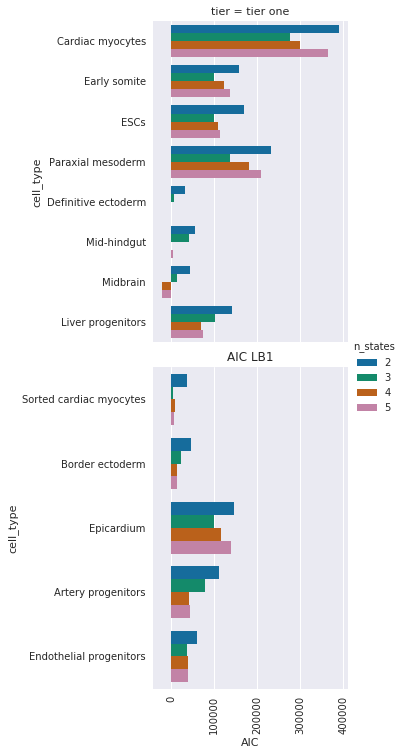

In [9]:
sns.catplot(x='AIC', y='cell_type', data=tog.replace(ct_replace),
           hue='n_states', row='tier', kind='bar', sharey=False)
plt.xticks(rotation=90)
plt.title('AIC LB1')

Text(0.5, 0, 'cell type')

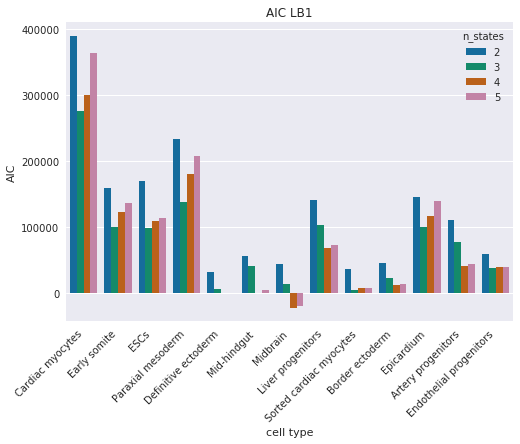

In [14]:
plt.style.use('seaborn')
plt.style.use('seaborn-colorblind')

p = sns.barplot(y='AIC', x='cell_type', data=tog.replace(ct_replace),
           hue='n_states')
plt.xticks(rotation=45, ha='right')
plt.title('AIC LB1')
plt.xlabel('cell type')

In [16]:
p.get_figure().savefig('../figs/SF10_aic_lb1_low_res.png',
         dpi=100, bbox_inches='tight')